# Import modules

In [ ]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seeds
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ativate GPU if needed
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Get latex commands
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

# Define initial parameters

In [ ]:
#Space grid
lb = 0
rb = 1
n_x = 64

#Define data points number
m = 400

#Data oscillations (how many sin/cos waves to superpose)
k = 10

#Number of output times
t_k = 10

#Boundary conditions type  - note for now only running Dirichlet boundary conditions
Boundary_cond = 'Dirichlet'
#Boundary conditions if Dirichlet
T_0 = 0
T_1 = 0

#Coefficients cap
max_a = 2.5
#TEMP
max_b = 2.5
#Epsilon value (for coefficient and model parameter caps)
epsilon = 0.0001

#Maximum coarsening factor for experiments
coars_max = 4

#Optimization parameters: regularization, batch size, train-val-test percentage split
batch_s = 16
train_size = 0.75
val_size = 0.125

#Example solution to plot
test_data = 20

# Define mesh, particular to the heat equation: $dt \sim dx^2$

We pick $n_t = 2\cdot dimension \cdot max(a(x,y))\cdot n_x^2$ and this will ensure stability of the Finite Differences algorithm since $\frac{a(x,y)d_t}{d_x^2} \leq \frac{max(a(x,y))d_t}{d_x^2} = \frac{1}{2\cdot dimension}$

In [ ]:
#Define space and time mesh - particular to the heat equation since dt ~ dx^2
n_t = int(2*max_a*n_x*n_x)

xmesh = torch.linspace(lb, rb, n_x).to(device)
tmesh = torch.linspace(0, 1, n_t).to(device)

dx = xmesh[1]-xmesh[0]
dt = tmesh[1]-tmesh[0]

# Define random initial conditions


In [ ]:
# Random initial conditions made up of a combination of sin(pi*k*x) functions with a given Fourier Spectrum
coef_vector = torch.ones(k).to(device)
for i in range(3,k):
  coef_vector[i] = 1/(i-1)

def initial_cond_dirichlet(x_mesh,k,T_0,T_1):
  coefs_rand = (torch.rand(k)-0.5).to(device)
  coefs_actual = coef_vector*coefs_rand
  func=torch.zeros(len(x_mesh)).to(device)
  for i in range(1, k+1):
    func+=coefs_actual[i-1]*torch.sin(torch.pi*i*x_mesh)
  func += (1-xmesh)*T_0+T_1*xmesh

  max = torch.max(func)
  min = torch.min(func)
  func = 2*func/(max-min)
  coefs_actual = 2*coefs_actual/(max-min)
  return func, coefs_actual

Text(0, 0.5, '$u(x,0)$')

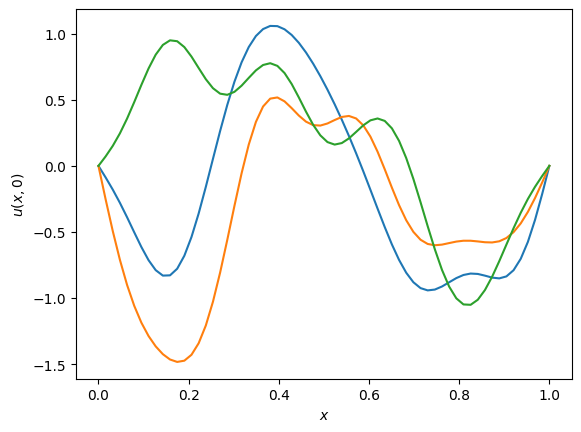

In [ ]:
#Visualize some data point
function_1, coefficients_1 = initial_cond_dirichlet(xmesh,k,T_0,T_1)
function_2, coefficients_2 = initial_cond_dirichlet(xmesh,k,T_0,T_1)
function_3, coefficients_3 = initial_cond_dirichlet(xmesh,k,T_0,T_1)

plt.plot(xmesh.cpu(), function_1.cpu())
plt.plot(xmesh.cpu(), function_2.cpu())
plt.plot(xmesh.cpu(), function_3.cpu())
plt.xlabel('$x$')
plt.ylabel('$u(x,0)$')

## Define the coeficients for the equatiion to model: $u_t = a(x)u_{xx}$

Capped between max_a and epsilon to ensure stability (hyperparameters defined above). The epsilon value just ensures the caps are not attained so that the model can learn the parameters exactly





In [ ]:
#Define the coefficients of the equation in the same way we defined our initial data (with a random function)
#and bound them under the stability region of the PDE
coefs_actual_a, _= initial_cond_dirichlet(xmesh,k,T_0,T_1)
coefs_actual_b, _= initial_cond_dirichlet(xmesh,k,T_0,T_1)
# coefs_actual_a= xmesh

coefs_actual_a = torch.maximum(torch.minimum(coefs_actual_a+1, torch.tensor(max_a - epsilon)), torch.tensor(epsilon))
# coefs_actual_b = torch.maximum(torch.minimum(coefs_actual_b+1, torch.tensor(max_b - epsilon)), torch.tensor(epsilon))
print(coefs_actual_b)

tensor([ 0.0000e+00, -1.6908e-01, -3.3245e-01, -4.8472e-01, -6.2107e-01,
        -7.3739e-01, -8.3026e-01, -8.9686e-01, -9.3484e-01, -9.4223e-01,
        -9.1753e-01, -8.5995e-01, -7.6981e-01, -6.4917e-01, -5.0226e-01,
        -3.3596e-01, -1.5982e-01,  1.4308e-02,  1.7310e-01,  3.0306e-01,
         3.9209e-01,  4.3116e-01,  4.1579e-01,  3.4703e-01,  2.3180e-01,
         8.2406e-02, -8.4710e-02, -2.5092e-01, -3.9770e-01, -5.0905e-01,
        -5.7351e-01, -5.8560e-01, -5.4637e-01, -4.6298e-01, -3.4744e-01,
        -2.1456e-01, -7.9610e-02,  4.3961e-02,  1.4650e-01,  2.2335e-01,
         2.7518e-01,  3.0745e-01,  3.2900e-01,  3.5021e-01,  3.8089e-01,
         4.2843e-01,  4.9637e-01,  5.8374e-01,  6.8518e-01,  7.9182e-01,
         8.9274e-01,  9.7674e-01,  1.0340e+00,  1.0578e+00,  1.0447e+00,
         9.9555e-01,  9.1448e-01,  8.0806e-01,  6.8400e-01,  5.4975e-01,
         4.1137e-01,  2.7282e-01,  1.3577e-01, -1.9461e-07])


In [ ]:
#plt.rcParams['text.usetex'] = True
# Plot predicted against actual coefficients
plt.plot(xmesh.cpu(), coefs_actual_a.cpu())
plt.xlabel(r'$x$')
plt.ylabel(r'$a(x)$')
plt.plot()

In [ ]:
#Construct the data
initial_conditions = torch.zeros(m,len(xmesh)).to(device)
coefficients = np.zeros((m,k))

if Boundary_cond == 'Dirichlet':
  for j in range(m):
    function, coefs = initial_cond_dirichlet(xmesh, k, T_0, T_1)
    initial_conditions[j] = function
    coefficients[j] = coefs.cpu()

In [ ]:
# Check lam<1/2 for stability
print(dt/dx)

tensor(0.0031)


# Fully resolved finite difference method, later coarsened
- first run the fully resolved FD method
- then averaged down to coarse mesh
- average in space x-factor adjacent grid point.
- sample in time, (the t-factor time step)


In [ ]:
#Define inputs and outputs of the model which are PDE intitial condition and averaged solution at t=1,..,t_k respectively

#Maximum t value to generate data
t_max = coars_max*t_k+1
solutions_exact = torch.zeros((1,t_max, n_x)).to(device)

filter = torch.tensor([1,-2,1]).float().to(device)
one_filter = torch.tensor([1]).float().to(device)
#Loop over all initial conditions (data points)
for j in range(m):
  #Create FD solution with initial condition
  sol = torch.zeros((t_max,n_x)).to(device)
  sol[0]=initial_conditions[j]

  #Solve forward in time (full grid) using finite differences
  for i in range(1,t_max):
    inp_pad = F.pad(sol[i-1].unsqueeze(0), (1,1), mode='circular')
    convolution = F.conv1d(inp_pad, filter.unsqueeze(0).unsqueeze(0), padding = 0)
    a_xx = convolution*coefs_actual_a
    upwind = torch.maximum(coefs_actual_b,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],-1)-sol[i-1])
    downwind = 0-torch.minimum(coefs_actual_b,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],1)-sol[i-1])
    sol[i] = sol[i-1] + upwind + downwind + dt/(dx**2)*a_xx
  #Add to solutions tensor
  solutions_exact = torch.cat((solutions_exact, sol.view(1,t_max,n_x)), 0)

In [ ]:
#Construct the data OOD from a different spectrum
OOD_spec = torch.ones(k).to(device)
for i in range(k-3):
  OOD_spec[i] = 1/(8-i)

def initial_cond_OOD(x_mesh,k,T_0,T_1):
  coefs_rand = (torch.rand(k)-0.5).to(device)
  coefs_actual = OOD_spec*coefs_rand
  func=torch.zeros(len(x_mesh)).to(device)
  for i in range(1, k+1):
    func+=coefs_actual[i-1]*torch.sin(torch.pi*i*x_mesh)
  func += (1-xmesh)*T_0+T_1*xmesh

  max = torch.max(func)
  min = torch.min(func)
  func = 2*func/(max-min)
  coefs_actual = 2*coefs_actual/(max-min)
  return func, coefs_actual


initial_conditions_OOD = torch.zeros(50,len(xmesh)).to(device)
coefficients_OOD = torch.zeros((50,k)).to(device)

if Boundary_cond == 'Dirichlet':
  for j in range(50):
    function, coefs = initial_cond_OOD(xmesh, k, T_0, T_1)
    initial_conditions_OOD[j] = function
    coefficients_OOD[j] = coefs

In [ ]:
solutions_exact_OOD = torch.zeros((1,t_max,n_x)).to(device)

for j in range(50):
  #Create FD solution with initial condition
  sol = torch.zeros((t_max,n_x)).to(device)
  sol[0]=initial_conditions_OOD[j]

  #Solve forward in time (full grid) using finite differences
  for i in range(1,t_max):
    inp_pad = F.pad(sol[i-1].unsqueeze(0), (1,1), mode='circular')
    convolution = F.conv1d(inp_pad, filter.unsqueeze(0).unsqueeze(0), padding = 0)
    a_xx = convolution*coefs_actual_a

    upwind = torch.maximum(coefs_actual_b,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],-1)-sol[i-1])
    downwind = 0-torch.minimum(coefs_actual_b,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],1)-sol[i-1])
    sol[i] = sol[i-1] + upwind + downwind + dt/(dx**2)*a_xx
  #Add to solutions tensor
  solutions_exact_OOD = torch.cat((solutions_exact_OOD, sol.view(1,t_max,n_x)), 0)

##Coarsening

Coarsen the space grid by x_factor defined below and sample solutions at the t_factor which corresponds to $x\_factor^2$ for stability

In [ ]:
#Define coarsening function
def coarsen(sol, n_x, x_factor, Boundary_cond, T_0, T_1):
  sol_avg = torch.zeros((t_k, int(n_x/x_factor))).to(device)
  inp_avg = torch.zeros((1,int(n_x/x_factor))).to(device)

  t_factor = x_factor

  #Done as a loop, fine for 1D but for higher dimensions using pooling layers
  for k in range(int(n_x/x_factor)):
    for i in range(t_k):
      sol_avg[i][k] = torch.mean(sol[t_factor*(i+1)][x_factor*k:x_factor*(k+1)])
    inp_avg[0][k]= torch.mean(sol[0][x_factor*k:x_factor*(k+1)])

  return inp_avg, sol_avg

In [ ]:
#Factor by which to coarsen x-grid (for easier to read code later)
x_factor = 2
n_x_new = int(n_x/x_factor)
#Corresponding t_factor
t_factor = x_factor

In [ ]:
#Define the inputs and outputs of the model (inputs are the initial conditons coarsened and
#outputs are the outputs at the sampled times coarsened in space too)
inputs = torch.zeros((1,n_x_new)).to(device)
outputs = torch.zeros((1,t_k,n_x_new)).to(device)

for j in range(1,m+1):
  # Coarsen the solution
  inp_avg, sol_avg = coarsen(solutions_exact[j], n_x, x_factor, Boundary_cond, T_0, T_1)

  #Conactenate our input-output pair to the respective tensors
  inputs = torch.cat((inputs, inp_avg.view(1,n_x_new)), 0)
  outputs = torch.cat((outputs, sol_avg.view(1,t_k,n_x_new)),0)

In [ ]:
inputs_OOD = torch.zeros((1,n_x_new)).to(device)
outputs_OOD = torch.zeros((1,t_k,n_x_new)).to(device)

for j in range(50):
  # Coarsen the solution
  inp_avg, sol_avg = coarsen(solutions_exact_OOD[j], n_x, x_factor, Boundary_cond, T_0, T_1)

  #Conactenate our input-output pair to the respective tensors
  inputs_OOD = torch.cat((inputs_OOD, inp_avg.view(1,n_x_new)), 0)
  outputs_OOD = torch.cat((outputs_OOD, sol_avg.view(1,t_k,n_x_new)),0)

inputs_OOD = torch.unsqueeze(inputs_OOD,1)

In [ ]:
# Format data into datsets and then load them as dataloaders
Data_heat_OOD = TensorDataset(inputs_OOD, outputs_OOD)
Heat_DataLoader_OOD = DataLoader(Data_heat_OOD, batch_size=batch_s, shuffle=True)

# Format data into pytorch data_loaders

In [ ]:
# Add an extra dimension to inputs for mathematical stability of matrices
inputs = torch.unsqueeze(inputs,1)

# Strip the first (zero) solution from input and output arrays (and exact solution arrays)
if (T_0 != 0 or T_1 != 0):
  inputs = inputs[1:][:][:]
  outputs = outputs[1:][:][:]
  solutions_exact = solutions_exact[1:][:][:]

In [ ]:
# Chek input and output sizes
print(inputs.size())
print(outputs.size())

torch.Size([401, 1, 32])
torch.Size([401, 10, 32])


In [ ]:
# Format data into datsets and then load them as dataloaders
Data_heat = TensorDataset(inputs, outputs)

Data_heat_train, Data_heat_val, Data_heat_test = torch.utils.data.random_split(Data_heat,
 [int(m*train_size), int(m*val_size), m+1-int(m*train_size)-int(m*val_size)])

Heat_DataLoader_train = DataLoader(Data_heat_train, batch_size=batch_s, shuffle=True)
Heat_DataLoader_val = DataLoader(Data_heat_val, batch_size=batch_s, shuffle=True)
Heat_DataLoader_test = DataLoader(Data_heat_test, batch_size=batch_s, shuffle=True)

In [ ]:
# #Subgrid example for Thesis
# fine = solutions_exact[77]
# coarse, _ = coarsen(fine, n_x, x_factor, 'Dirichlet', T_0, T_1)

# plt.plot(xmesh.cpu(), fine[0])
# plt.plot(x_mesh_avg.cpu(), coarse[0])
# plt.xlabel(r'$x$')
# plt.ylabel(r'$u(x, t_k)$')
# plt.legend(['Fine grid','Coarse grid'])

In [ ]:
from numpy.lib.twodim_base import vander
from numpy.lib.shape_base import apply_over_axes
# Defin the Coarsened FD method as a neural net
class IndividualLayer_PDE(nn.Module):
  """This class implements an individual layer of the coarsened grid FD method"""

  def __init__(self, xmesh, dt):
    """
      xmesh: int
        size of coarsened grid
      W: matrix
        Matrix for the coarsened FD method
    """
    super(IndividualLayer_PDE, self).__init__()

    # Initialize parameters randomly in (-0.5,0.5)
    self.coefs_a = torch.nn.Parameter((torch.rand(xmesh)-0.5))
    self.coefs_b = torch.nn.Parameter((torch.rand(xmesh)-0.5))

    self.filter = torch.tensor([1,-2,1]).to(device).float()
    self.one_filter = torch.tensor([1]).to(device).float()

  def forward(self, v):
    """
      x: Tensor
        Coarsened inputs at a given time

      Outputs: Returns the predicted coarsened outputs at the next time
    """
    # Bound coeficients between zero and max_a for stability
    b_x = max_b*torch.tanh(self.coefs_b)
    a_x = max_a*torch.sigmoid(self.coefs_a)

    # Implement the FD method on the coarsened grid (to learn parameters through back-propagation) - same as when generating the non-coarsened data
    inp_pad = F.pad(v, (1,1), mode='circular')
    convolution = F.conv1d(inp_pad, filter.unsqueeze(0).unsqueeze(0), padding = 0)
    a_xx = convolution*a_x/(x_factor)

    upwind = torch.maximum(b_x,torch.tensor(0))*dt/dx*(torch.roll(v,shifts=(-1), dims=(-1))-v)
    downwind = 0-torch.minimum(b_x,torch.tensor(0))*dt/dx*(torch.roll(v,shifts=(1), dims=(-1))-v)

    y = v + upwind + downwind + dt/(dx**2)*a_xx
    return y

In [ ]:
class PDE_Solver(nn.Module):
  """This class implements the Full Coarsened FD method"""

  def __init__(self, xmesh, dt):
    """
      xmesh: int
        size of coarsened grid
      W: matrix
        Matrix for the coarsened FD method
    """
    super(PDE_Solver, self).__init__()

    # Call the individual layer class defined previously
    self.layer = IndividualLayer_PDE(xmesh, dt)

  def forward(self, x):
    """
      x: Tensor
        Coarsened inputs to the network at time 0

      Outputs: Returns the coarsened outputs at the next 10 times
    """

    # Call the individual layer (FD method) t_k times to generate the next t_k time predictions in the coarsened grid
    prev = x
    next = self.layer(prev)
    y = next
    prev = next

    for i in range(t_k-1):
      next = self.layer(prev)
      y = torch.cat((y, next),1)
      prev = next

    return y

# Define the Training and Validation for the model

In [ ]:
# Define one training epoch through the train and valudate functions
# Each call to train and validate runs a training and validation epoch
# This is generic code that serves to train and validate any ML model with Pytorch
def train(model, dataloader, optimizer, criterion):
    train_loss = 0.
    model.train()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(source)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end = time.time()
    train_loss /= len(dataloader)
    train_time = end - start
    return train_loss, train_time

def validate(model, dataloader, criterion):
    val_loss = 0.
    model.eval()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        output = model(source)
        loss = criterion(output, target)
        val_loss += loss.item()

    end = time.time()
    val_loss /= len(dataloader)
    val_time = end - start
    return val_loss, val_time

# Run it / Train the Model and plot learning dynamics


In [ ]:
# Define the model as the PDE_Solver class and feed in the coarsed grid size and average W matrix
# Optimize with Adam and our loss is the L_2 loss
# def reg_loss(output, target):
#   l2_loss = torch.nn.MSELoss()
#   return l2_loss(output, target) +

model = PDE_Solver(n_x_new, dt).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = 0)
criterion = torch.nn.MSELoss()

# Collect the results of the training and validation
results = {
    "train_losses": [],
    "train_times":  [],
    "valid_losses": [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_time":    0.
}

if __name__ == "__main__":
    torch.cuda.empty_cache()
    n_epochs = 1000

    for epoch in range(n_epochs):
        train_loss, train_time = train(model, Heat_DataLoader_train, optimizer, criterion)
        valid_loss, valid_time = validate(model, Heat_DataLoader_val, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_times"].append(valid_time)

    test_loss, test_time = validate(model, Heat_DataLoader_test, criterion)
    print(f"== Test Loss: {test_loss} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_time"] = test_time

Epoch: 0
Train Loss: 0.0016127184376512702 | Train Time: 0.358
Valid Loss: 0.00199841198627837 | Valid Time: 0.023
Epoch: 1
Train Loss: 0.0015768760533415172 | Train Time: 0.233
Valid Loss: 0.0016779854777269065 | Valid Time: 0.023
Epoch: 2
Train Loss: 0.0015463978542309058 | Train Time: 0.252
Valid Loss: 0.0016049829428084195 | Valid Time: 0.024
Epoch: 3
Train Loss: 0.0015167610437952373 | Train Time: 0.310
Valid Loss: 0.0015685545222368091 | Valid Time: 0.029
Epoch: 4
Train Loss: 0.001483283949231631 | Train Time: 0.340
Valid Loss: 0.0020276627619750798 | Valid Time: 0.028
Epoch: 5
Train Loss: 0.0014441580768968713 | Train Time: 0.340
Valid Loss: 0.0015194412262644619 | Valid Time: 0.029
Epoch: 6
Train Loss: 0.0014182487870321463 | Train Time: 0.327
Valid Loss: 0.0015047456254251301 | Valid Time: 0.028
Epoch: 7
Train Loss: 0.001383615222661511 | Train Time: 0.368
Valid Loss: 0.0014386590919457376 | Valid Time: 0.032
Epoch: 8
Train Loss: 0.0013540274077585262 | Train Time: 0.382
Valid

Text(0, 0.5, 'MSE')

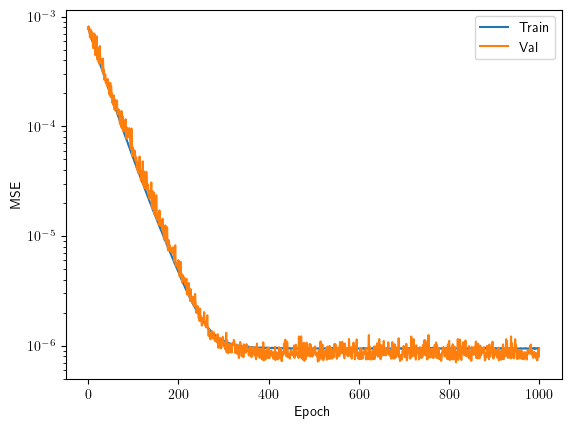

In [ ]:
# Plot the training and validation losses
plt.plot(results["train_losses"])
plt.plot(results["valid_losses"])
plt.legend(['Train', 'Val'])
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('MSE')

In [ ]:
# Print the learned parameters and collect the coeafficients found by the model
results_coefs_a = np.zeros(int(n_x/x_factor))
results_coefs_b = np.zeros(int(n_x/x_factor))
for i, param in enumerate(model.parameters()):
  print(param)
  if i ==0:
    for j in range(int(n_x/x_factor)):
      results_coefs_a[j]=max_a*torch.sigmoid(param[j])
  elif i==1:
    for j in range(int(n_x/x_factor)):
      results_coefs_b[j]=max_b*torch.tanh(param[j])

Parameter containing:
tensor([-0.5235, -0.9240, -1.2431, -1.6530, -2.0122, -2.2738, -2.2709, -1.7972,
        -1.1302, -0.4390,  0.2752,  0.9470,  1.5705,  2.0110,  2.0351,  1.7650,
         1.4421,  1.1832,  0.9670,  0.8266,  0.7940,  0.7985,  0.8200,  0.8040,
         0.6661,  0.4447,  0.2311,  0.0093, -0.1748, -0.2219, -0.3023, -0.4520],
       requires_grad=True)
Parameter containing:
tensor([ 1.3272, -0.0113,  0.0703,  0.0769,  0.0263,  0.0025, -0.0176, -0.0360,
         0.0049,  0.0559,  0.1401,  0.1732,  0.1601,  0.1447,  0.0992,  0.0499,
        -0.0193, -0.1321, -0.2724, -0.4340, -0.5534, -0.5769, -0.5099, -0.3972,
        -0.3144, -0.3013, -0.3479, -0.4389, -0.5104, -0.4507, -0.0578, -1.7753],
       requires_grad=True)


# Plot learned coefficients agains actual coeficients

We use interpolation when comparing soltuions for more coarsened grids (i.e. we interpolate back to the original grid size)

[]

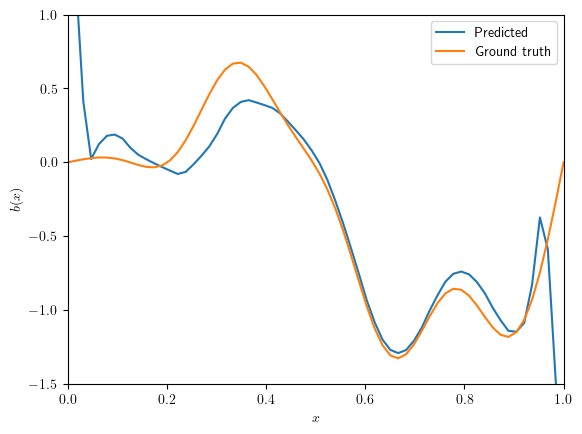

In [ ]:
#Average the x_mesh to get approprioate x-coordinates (could used pooling but for 1D averaging is good enough)
x_mesh_avg = torch.zeros(n_x_new).to(device)
for i in range(n_x_new):
  x_mesh_avg[i] = torch.mean(xmesh[x_factor*i:x_factor*(i+1)])
x_mesh_avg[0]=0
x_mesh_avg[-1]=1

# Get data to interpolate - we ignore first and last two coeficients since they are not as accurate due to boundary conditions
x_vals = x_mesh_avg
y_vals = results_coefs_b

coefs_interp = np.interp(xmesh.cpu(), x_vals.cpu(), y_vals)
plt.rcParams['text.usetex'] = True

##TEMP
acc = coefs_actual_b

# Plot predicted against actual coefficients
plt.plot(xmesh.cpu(), coefs_interp)
plt.plot(xmesh.cpu(), acc)
# plt.scatter(x_vals.cpu(), y_vals, s=10)
plt.xlim([x_vals[0].cpu(), x_vals[-1].cpu()])
plt.ylim(-1.5, 1)
plt.legend(['Predicted', 'Ground truth'])
plt.xlabel(r'$x$')
plt.ylabel(r'$b(x)$')
plt.plot()

[]

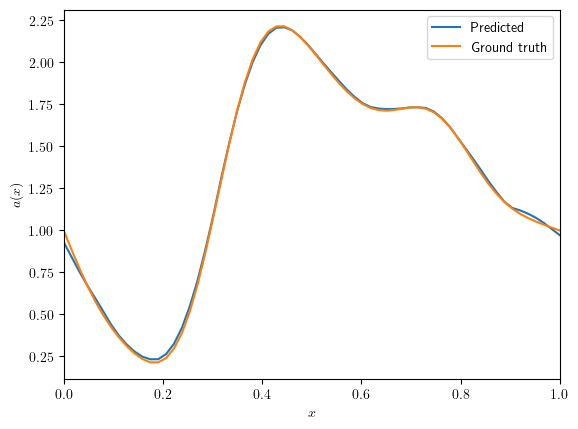

In [ ]:
# Get data to interpolate - we ignore first and last two coeficients since they are not as accurate due to boundary conditions
x_vals = x_mesh_avg
y_vals2 = results_coefs_a

coefs_interp2 = np.interp(xmesh.cpu(), x_vals.cpu(), y_vals2)
plt.rcParams['text.usetex'] = True

##TEMP
acc = coefs_actual_a

# Plot predicted against actual coefficients
plt.plot(xmesh.cpu(), coefs_interp2)
plt.plot(xmesh.cpu(), acc)
# plt.scatter(x_vals.cpu(), y_vals, s=10)
plt.xlim([x_vals[0].cpu(), x_vals[-1].cpu()])
plt.legend(['Predicted', 'Ground truth'])
plt.xlabel(r'$x$')
plt.ylabel(r'$a(x)$')
plt.plot()

# Plot an example of a modelled solution against its fully resolved function

In [ ]:
#Plot an example solution
test_data = 3
sol_model_act = solutions_exact[test_data]

#Sample our solution to 10 time steps
sol_model_act_avg = torch.zeros((t_k, n_x)).to(device)
for i in range (t_k):
  sol_model_act_avg[i] = sol_model_act[t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input
sol_model_pred = model(inputs[test_data].unsqueeze(0)).squeeze().detach().cpu().numpy()

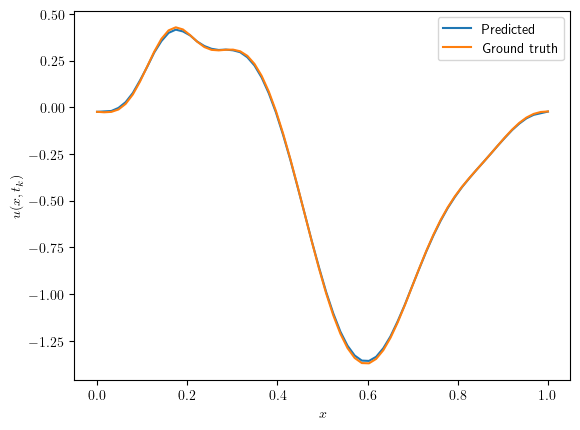

In [ ]:
#Plot our solutions to compare
test_time = 9
sol_interp = np.interp(xmesh.cpu(), x_mesh_avg.cpu(), sol_model_pred[test_time-1])

plt.plot(xmesh.cpu(), sol_interp)
plt.plot(xmesh.cpu(), sol_model_act_avg[test_time-1].cpu())
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x, t_k)$')
plt.legend(['Predicted','Ground truth'])

In [ ]:
# Check the error on a specific input after passing it through the model and checking it with its output
y = model(inputs[190].unsqueeze(0)).squeeze()[1]
z = outputs[190][1]
err = abs(y-z)
torch.max(err)

tensor(0.0029, grad_fn=<MaxBackward1>)

#Now we implement a fully connected neural net

Working with the heat equaiton $$u_t = a(x)u_{xx}$$

Input data - Initial conditions

For now working with Dirichlet Boundary conditions

Initial conditions: $$u(x,0) = (1-x)T_0 +xT_1 + \sum_{i=1}^k c_isin(\pi ix)$$

$k = 10$ for the results presented today (note that larger $k$ values require finer grid size $n_x$ to generate good results).


In [ ]:
# Define the Coarsened FD method as a neural net
# Option 1: run the coede as is for the Convolutional neural netword
# Option 2: uncomment the section under #Define a simple 2-layer ReLU MLP and comment out the section under #Define a simple 2-layer ReLU conv net
# to run the fully cinnected network
class IndividualLayer_NN(nn.Module):
  """This class implements an individual layer of the coarsened grid FD method"""

  def __init__(self, xmesh):
    """
      xmesh: int
        size of coarsened grid
      W: matrix
        Matrix for the coarsened FD method
    """
    super(IndividualLayer_NN, self).__init__()

    #Define a simple 2-layer ReLU MLP
    # self.xmesh = xmesh
    # self.layer1 = nn.Linear(self.xmesh, 32)
    # self.activation = nn.ReLU()
    # self.layer2 = nn.Linear(32, self.xmesh)

    #Define a simple 2-layer ReLU conv net
    self.xmesh = xmesh
    self.layer1 = nn.Conv1d(1,16,3,1,1)
    self.activation = nn.ReLU()
    self.layer2 = nn.Conv1d(16,1,3,1,1)

  def forward(self, x):
    """
      x: Tensor
        Coarsened inputs at a given time

      Outputs: Returns the predicted coarsened outputs at the next time
    """
    #Linear layer 1
    x2 = self.layer1(x)
    #ReLU
    x3 = self.activation(x2)
    #Linear layer 2
    y = self.layer2(x3)
    return y

In [ ]:
class NN_Solver(nn.Module):
  """This class implements the Full Coarsened FD method"""

  def __init__(self, xmesh):
    """
      xmesh: int
        size of coarsened grid
      W: matrix
        Matrix for the coarsened FD method
    """
    super(NN_Solver, self).__init__()

    # Call the individual layer class defined previously for the t_k = 10 timesteps (manually change if t_k changes)
    self.layer1 = IndividualLayer_NN(xmesh)
    self.layer2 = IndividualLayer_NN(xmesh)
    self.layer3 = IndividualLayer_NN(xmesh)
    self.layer4 = IndividualLayer_NN(xmesh)
    self.layer5 = IndividualLayer_NN(xmesh)
    self.layer6 = IndividualLayer_NN(xmesh)
    self.layer7 = IndividualLayer_NN(xmesh)
    self.layer8 = IndividualLayer_NN(xmesh)
    self.layer9 = IndividualLayer_NN(xmesh)
    self.layer10 = IndividualLayer_NN(xmesh)

  def forward(self, x):
    """
      x: Tensor
        Coarsened inputs to the network at time 0

      Outputs: Returns the coarsened outputs at the next 10 times
    """

    # Call the individual layer (FD method) t_k = 10 times to generate the next 10 time predictions in the coarsened grid
    x1=self.layer1(x)
    x2=self.layer2(x1)
    x3=self.layer3(x2)
    x4=self.layer4(x3)
    x5=self.layer5(x4)
    x6=self.layer6(x5)
    x7=self.layer7(x6)
    x8=self.layer8(x7)
    x9=self.layer9(x8)
    x10=self.layer10(x9)

    # Concatenate the outputs to check with the original coarsened outputs
    y = torch.cat((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10),1)
    return y

In [ ]:
# Define the model as the PDE_Solver class and feed in the coarsed grid size and average W matrix
# Optimize with Adam and our loss is the L_2 loss
modelNN = NN_Solver(n_x_new).to(device)
optimizer = optim.Adam(modelNN.parameters(), weight_decay=0)
criterion = torch.nn.MSELoss()

# Collect the results of the training and validation
resultsNN = {
    "train_losses": [],
    "train_times":  [],
    "valid_losses": [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_time":    0.
}

if __name__ == "__main__":
    torch.cuda.empty_cache()
    n_epochs = 50

    for epoch in range(n_epochs):
        train_loss, train_time = train(modelNN, Heat_DataLoader_train, optimizer, criterion)
        valid_loss, valid_time = validate(modelNN, Heat_DataLoader_val, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss} | Valid Time: {valid_time:.3f}")

        resultsNN["train_losses"].append(train_loss)
        resultsNN["train_times"].append(train_time)
        resultsNN["valid_losses"].append(valid_loss)
        resultsNN["valid_times"].append(valid_time)

    test_loss, test_time = validate(modelNN, Heat_DataLoader_test, criterion)
    print(f"== Test Loss: {test_loss} | Test Time: {test_time:.3f} ==")
    resultsNN["test_loss"] = test_loss
    resultsNN["test_time"] = test_time

Epoch: 0
Train Loss: 0.44322821811625834 | Train Time: 0.265
Valid Loss: 0.3867851570248604 | Valid Time: 0.015
Epoch: 1
Train Loss: 0.39935236698702764 | Train Time: 0.332
Valid Loss: 0.3577030450105667 | Valid Time: 0.027
Epoch: 2
Train Loss: 0.33007832969489853 | Train Time: 0.418
Valid Loss: 0.2526662349700928 | Valid Time: 0.023
Epoch: 3
Train Loss: 0.25396402180194855 | Train Time: 0.385
Valid Loss: 0.2165769562125206 | Valid Time: 0.024
Epoch: 4
Train Loss: 0.1734558265460165 | Train Time: 0.401
Valid Loss: 0.12110420130193233 | Valid Time: 0.026
Epoch: 5
Train Loss: 0.09927976837283686 | Train Time: 0.405
Valid Loss: 0.06402073055505753 | Valid Time: 0.027
Epoch: 6
Train Loss: 0.04731880197007405 | Train Time: 0.427
Valid Loss: 0.021851674187928438 | Valid Time: 0.031
Epoch: 7
Train Loss: 0.01838104760176257 | Train Time: 0.446
Valid Loss: 0.014151740586385131 | Valid Time: 0.015
Epoch: 8
Train Loss: 0.014034556813145938 | Train Time: 0.259
Valid Loss: 0.012818202143535018 | Va

Text(0, 0.5, 'log(MSE)')

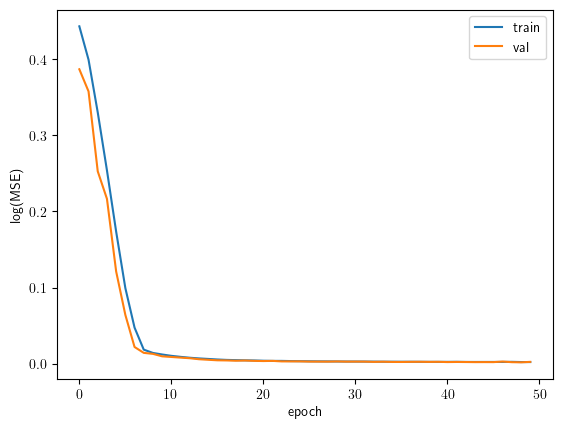

In [ ]:
# Plot the training and validation losses
plt.plot(resultsNN["train_losses"])
plt.plot(resultsNN["valid_losses"])
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('log(MSE)')

In [ ]:
# Plot an example solution
sol_model_act = solutions_exact[test_data]

#Sample our solution to t_k time steps
sol_model_act_avg = torch.zeros((t_k, n_x)).to(device)
for i in range (t_k):
  sol_model_act_avg[i] = sol_model_act[t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input
sol_model_pred_NN = modelNN(inputs[test_data].unsqueeze(0)).squeeze().detach().cpu().numpy()

Text(0, 0.5, '$u(x,t_9)$')

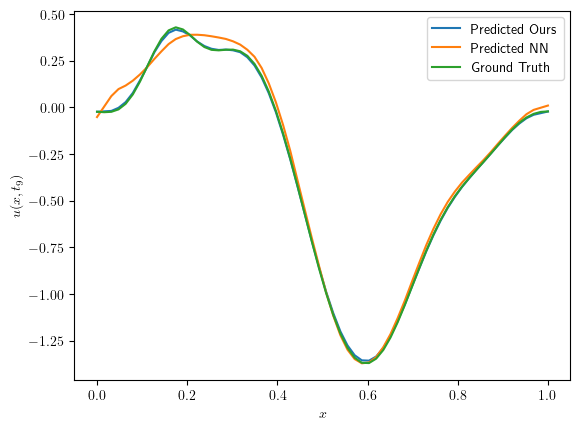

In [ ]:
#Plot our solutions to compare
test_time = 9
sol_interp_NN = np.interp(xmesh.cpu(), x_mesh_avg.cpu(), sol_model_pred_NN[test_time-1])
sol_interp = np.interp(xmesh.cpu(), x_mesh_avg.cpu(), sol_model_pred[test_time-1])

plt.plot(xmesh.cpu(), sol_interp)
plt.plot(xmesh.cpu(), sol_interp_NN)
plt.plot(xmesh.cpu(), sol_model_act_avg[test_time-1].cpu())
plt.legend(['Predicted Ours', 'Predicted NN', 'Ground Truth'])
plt.xlabel('$x$')
plt.ylabel(f'$u(x,t_{test_time})$')

In [ ]:
#Get the test loss on in-distribution and out-of-distribution data
test_loss_OOD, test_time_OOD = validate(model, Heat_DataLoader_OOD, criterion)
test_loss_OOD_NN, test_time_OOD_NN = validate(modelNN, Heat_DataLoader_OOD, criterion)

In [ ]:
#Get pur normalization constants
u_avg_OOD = torch.mean(outputs_OOD)
u_stdev_OOD = torch.mean((outputs_OOD - u_avg_OOD)**2)

u_avg = torch.mean(outputs)
u_stdev = torch.mean((outputs - u_avg)**2)

Text(0, 0.5, '$u(x,t_9)$')

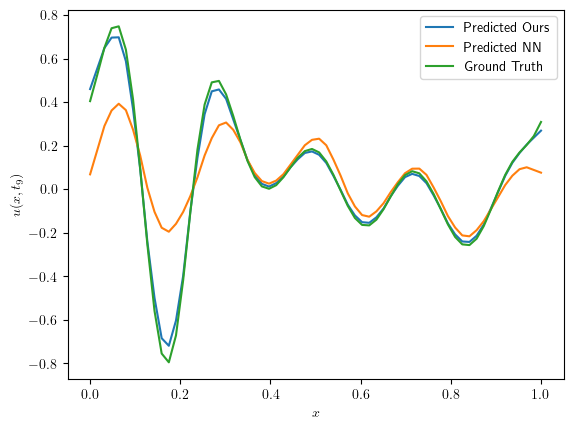

In [ ]:
#Sample our solution to t_k time steps
visual = 49
OOD_avg = torch.zeros((t_k, n_x)).to(device)
for i in range (t_k):
  OOD_avg[i] = solutions_exact_OOD[visual][t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input for both models
OOD_pred_RCNN = model(inputs_OOD[visual+1].unsqueeze(0)).squeeze().detach().cpu().numpy()
OOD_pred_NN = modelNN(inputs_OOD[visual+1].unsqueeze(0)).squeeze().detach().cpu().numpy()

#Plot our solutions to compare
test_time = 9
OOD_interp_RCNN = np.interp(xmesh.cpu(), x_mesh_avg.cpu(), OOD_pred_RCNN[test_time-1])
OOD_interp_NN = np.interp(xmesh.cpu(), x_mesh_avg.cpu(), OOD_pred_NN[test_time-1])

plt.plot(xmesh.cpu(), OOD_interp_RCNN)
plt.plot(xmesh.cpu(), OOD_interp_NN)
plt.plot(xmesh.cpu(), OOD_avg[test_time-1].cpu())
plt.legend(['Predicted Ours', 'Predicted NN','Ground Truth'], loc = 1)
plt.xlabel('$x$')
plt.ylabel(f'$u(x,t_{test_time})$')

Text(0, 0.5, '$\\mathrm{E}[c_i^2]$')

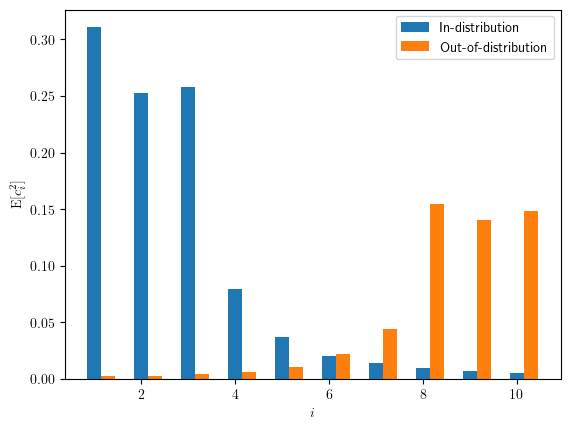

In [ ]:
#Visualize the spectrum of the coefficients
index = np.arange(k)+1
coefficients_mean = np.mean(coefficients**2, 0)
coefficients_mean_OOD = np.mean((coefficients_OOD**2).cpu().numpy(), 0)

plt.bar(index, coefficients_mean, 0.3)
plt.bar(index+ 0.3, coefficients_mean_OOD, 0.3)
plt.legend(['In-distribution', 'Out-of-distribution'], loc = 1)
plt.xlabel('$i$')
plt.ylabel(r'$\mathrm{E}[c_i^2]$')

In [ ]:
#Graph subgrids - note that this was done accros several runs, and the code needs to be uncommented and commented as needed
#to avoid overwriting the arrays and depending on the neural network model being run
factors = np.array([256,128,64,32])
losses_PDE_train = np.ones(4)
losses_PDE = np.ones(4)
losses_PDE_OOD = np.ones(4)
losses_NN_train = np.ones(4)
losses_NN = np.ones(4)
losses_NN_OOD = np.ones(4)
losses_Conv_train = np.ones(4)
losses_Conv = np.ones(4)
losses_Conv_OOD = np.ones(4)

In [ ]:
#Graph subgrids (adjust run and model as needed)
run = 1
losses_PDE_train[run-1] = (results["train_losses"][-1]/u_stdev)**0.5
losses_PDE[run-1] = (results["test_loss"]/u_stdev)**0.5
losses_PDE_OOD[run-1] = (test_loss_OOD/u_stdev_OOD)**0.5
losses_NN_train[run-1] = (resultsNN["train_losses"][-1]/u_stdev)**0.5
losses_NN[run-1] = (resultsNN["test_loss"]/u_stdev)**0.5
losses_NN_OOD[run-1] = (test_loss_OOD_NN/u_stdev_OOD)**0.5
losses_Conv_train[run-1] = (resultsNN["train_losses"][-1]/u_stdev)**0.5
losses_Conv[run-1] = (resultsNN["test_loss"]/u_stdev)**0.5
losses_Conv_OOD[run-1] = (test_loss_OOD_NN/u_stdev_OOD)**0.5

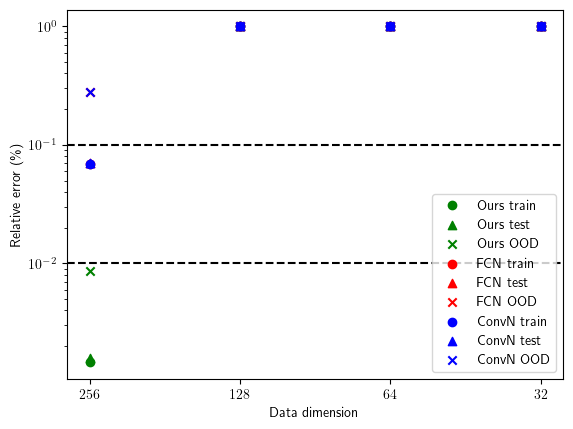

In [ ]:
#Graph subgrids
import matplotlib.ticker as mticker
plt.rc('axes.formatter', useoffset=False)

plt.scatter(factors, losses_PDE_train, c = 'green')
plt.scatter(factors, losses_PDE, c = 'green', marker = '^')
plt.scatter(factors, losses_PDE_OOD, c = 'green', marker = 'x')
plt.scatter(factors, losses_NN_train, c = 'red')
plt.scatter(factors, losses_NN, c = 'red', marker = '^')
plt.scatter(factors, losses_NN_OOD, c = 'red', marker = 'x')
plt.scatter(factors, losses_Conv_train, c = 'blue')
plt.scatter(factors, losses_Conv, c = 'blue', marker = '^')
plt.scatter(factors, losses_Conv_OOD, c = 'blue', marker = 'x')
plt.legend(['Ours train', 'Ours test', 'Ours OOD', 'FCN train', 'FCN test', 'FCN OOD', 'ConvN train', 'ConvN test', 'ConvN OOD'], loc = 4)

plt.xlabel('Data dimension')
plt.ylabel('Relative error (\%)')
plt.yscale('log')
plt.xscale('log', base = 2)
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().invert_xaxis()

plt.axhline(y = 0.1, color = 'black', linestyle = '--')
plt.axhline(y = 0.01, color = 'black', linestyle = '--')

plt.show()